<a href="https://www.kaggle.com/code/aletbm/cardiovascular-diseases-eda-modeling?scriptVersionId=142170758" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install missingno
!pip install mplcyberpunk

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv


# Load of libraries

In [3]:
import plotly.graph_objects as go
import plotly.express as px

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report


import missingno as msno

import mplcyberpunk
import random

plt.style.use("cyberpunk")

In [4]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

# 📜 About this dataset
## Feature description
+ **Age**: age of the patient [years]
+ **Sex**: sex of the patient [M: Male, F: Female]
+ **ChestPainType**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
+ **RestingBP**: resting blood pressure [mm Hg]
+ **Cholesterol**: serum cholesterol [mm/dl]
+ **FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
+ **RestingECG**: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
+ **MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]
+ **ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]
+ **Oldpeak**: oldpeak = ST [Numeric value measured in depression]
+ **ST_Slope**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
+ **HeartDisease**: output class [1: heart disease, 0: Normal]

In [5]:
df = pd.read_csv('/kaggle/input/heart-failure-prediction/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
df.shape

(918, 12)

In [7]:
df.drop_duplicates()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [9]:
continuos_f = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
categorical_f = ["ChestPainType", "RestingECG", "ST_Slope"]
binaries_f = ["Sex", "FastingBS", "ExerciseAngina"]

<AxesSubplot:>

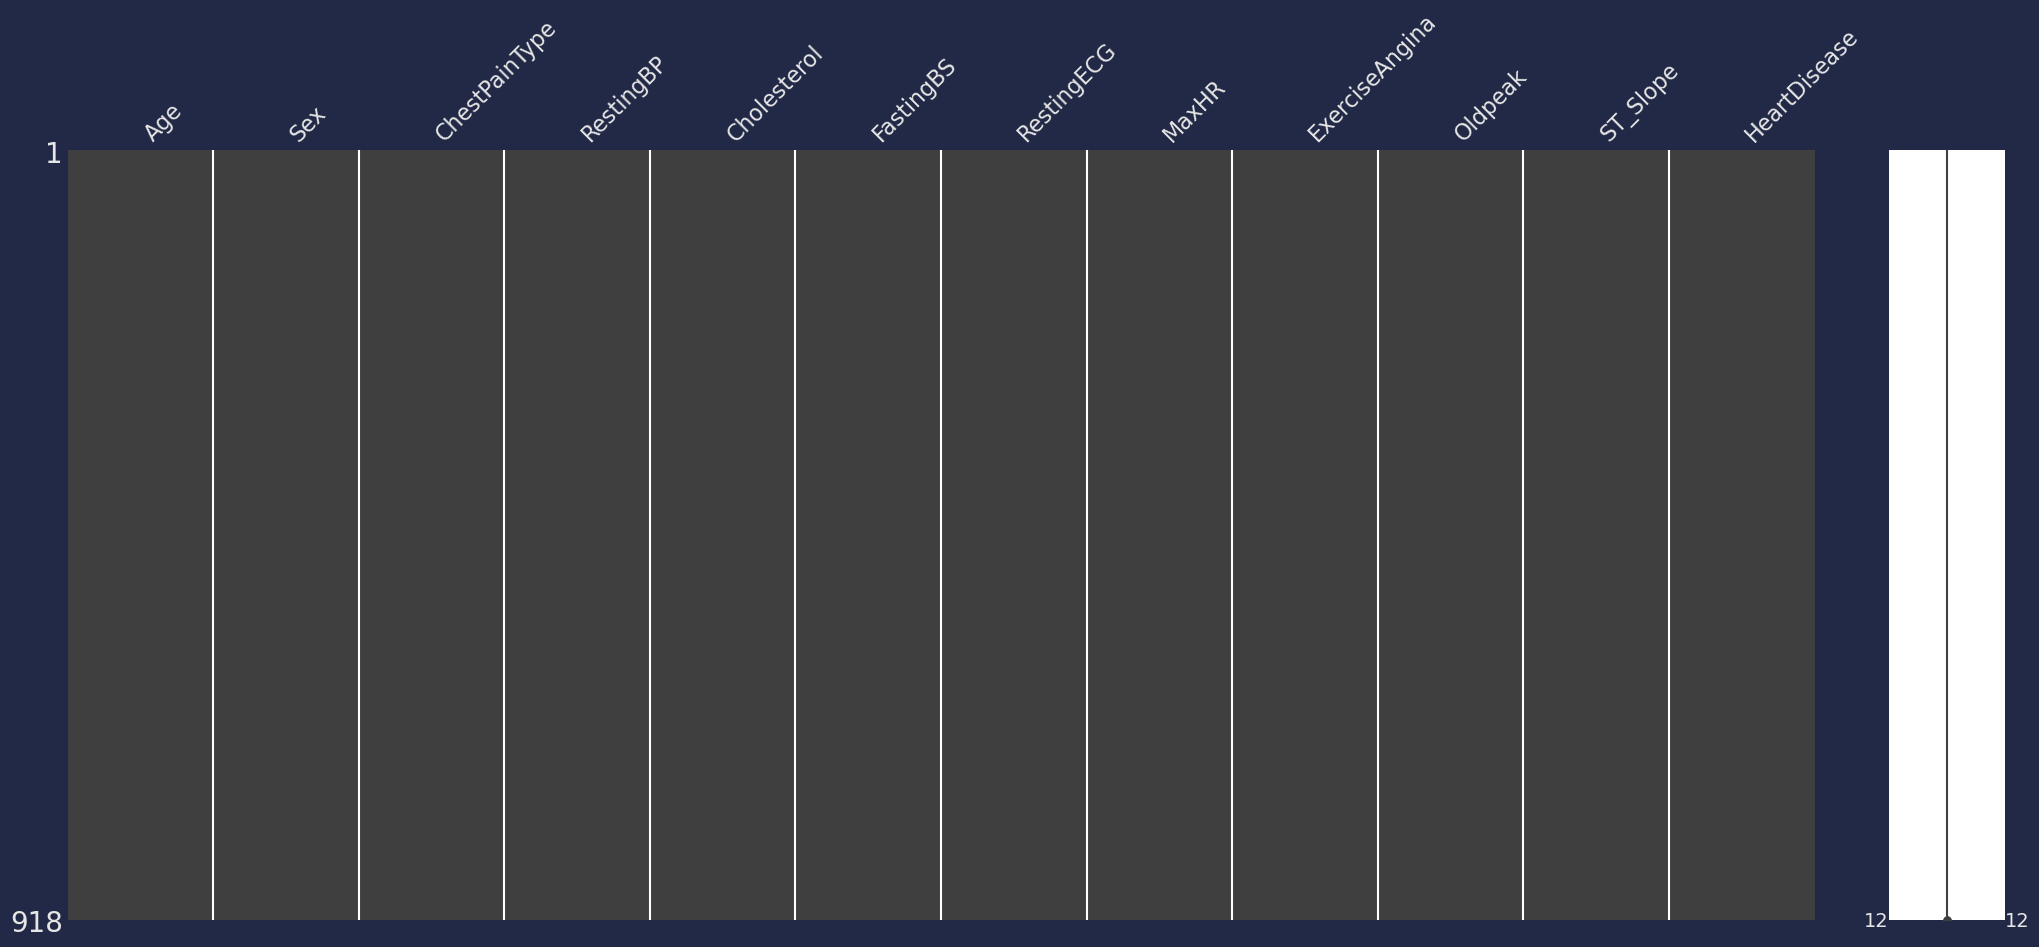

In [10]:
msno.matrix(df)

In [11]:
df[continuos_f].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


****

# 📊 EDA and data wrangling 

<Figure size 640x480 with 0 Axes>

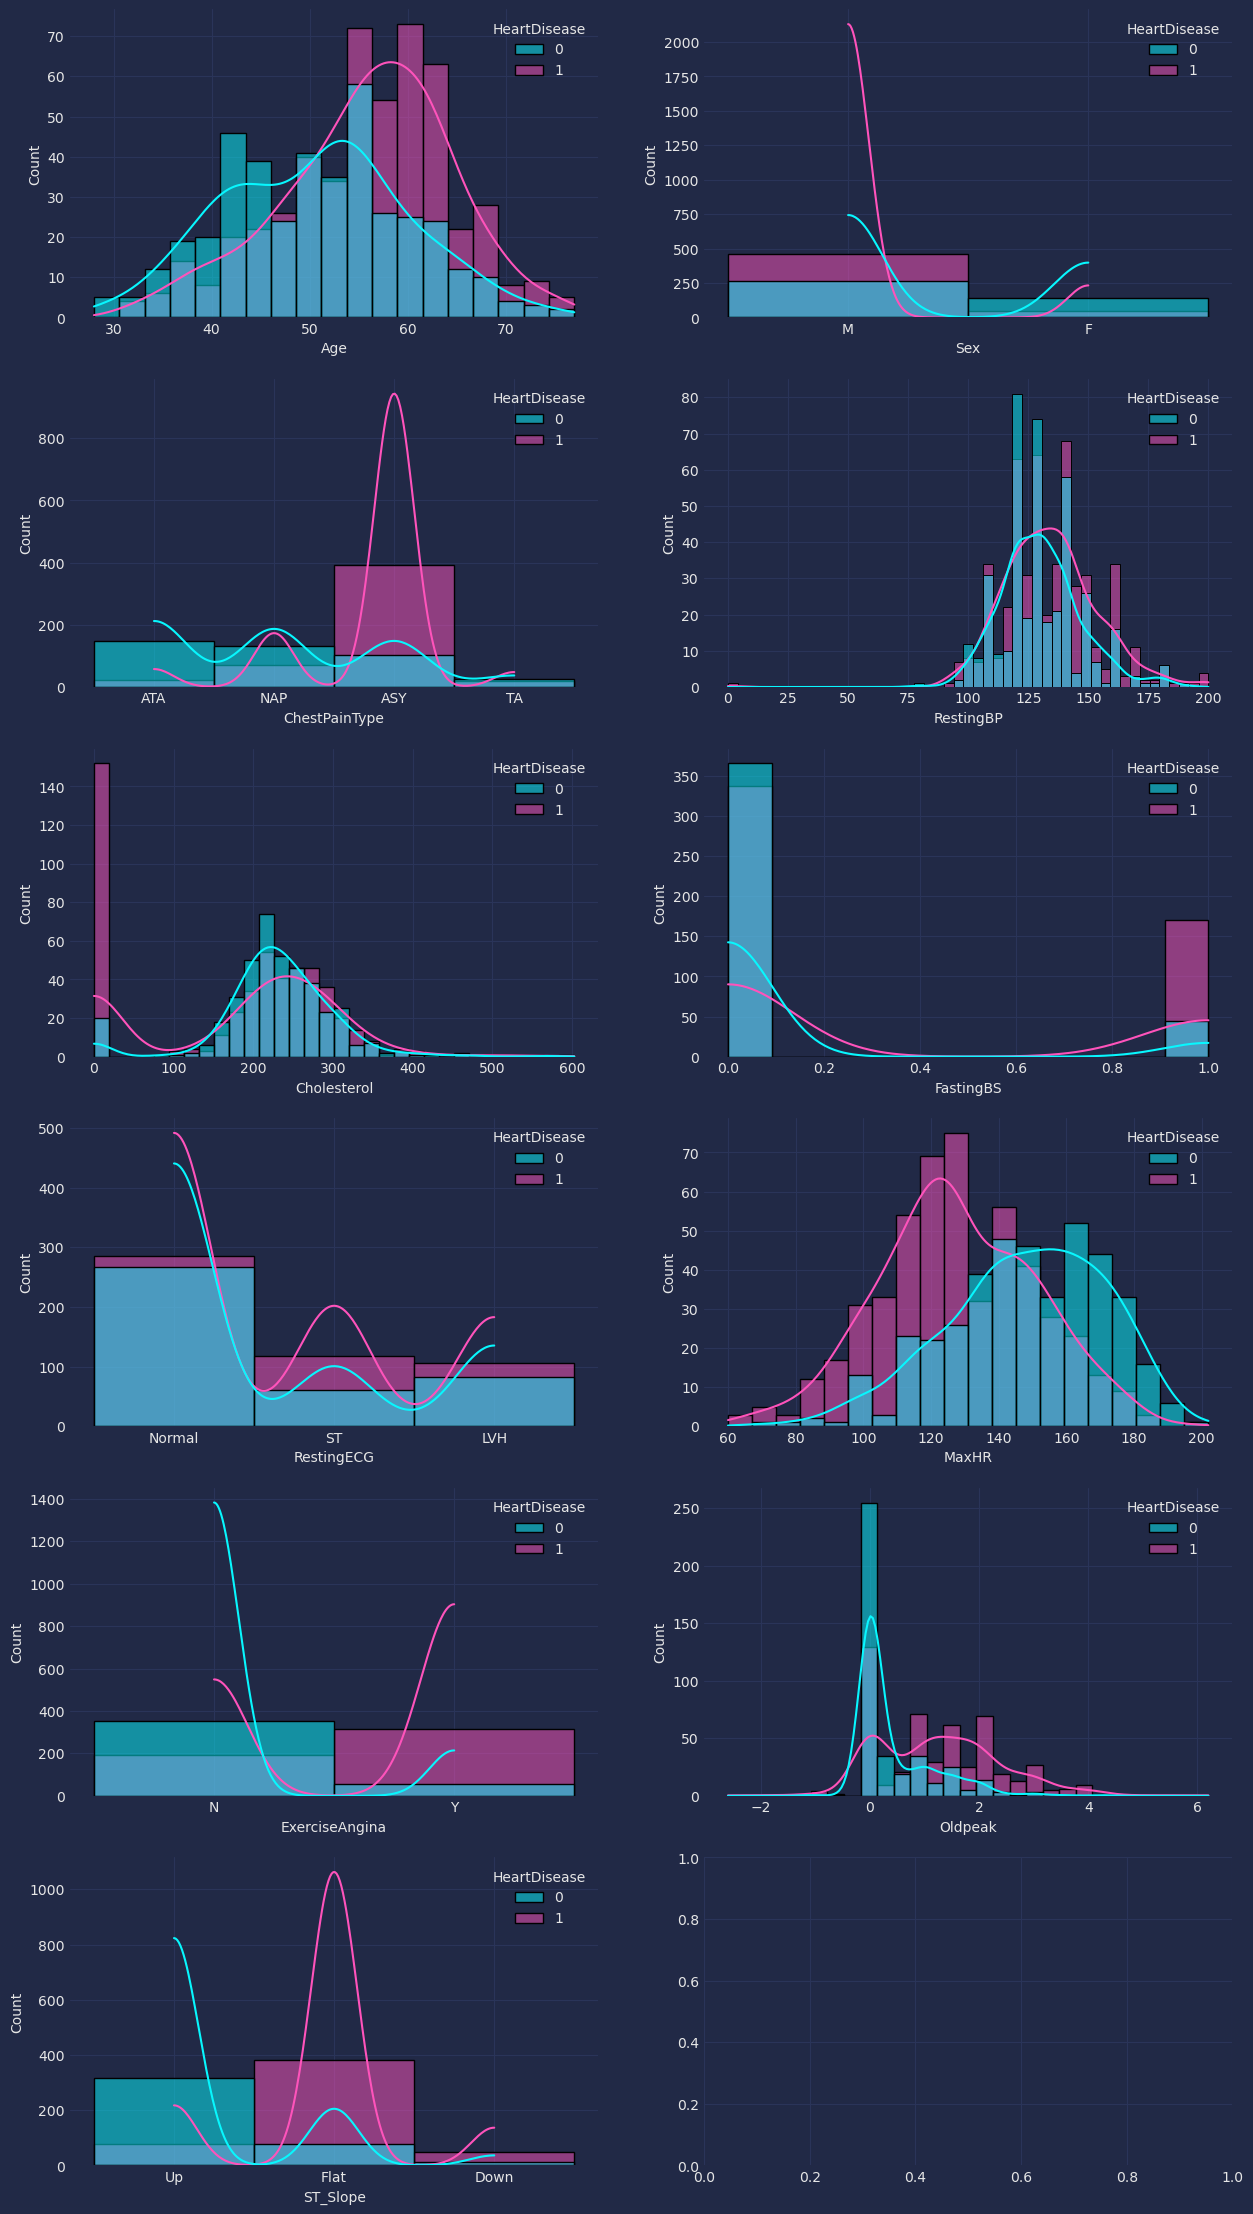

In [12]:
plt.subplots_adjust(hspace=0.2)

fig, axs = plt.subplots(6, 2, figsize=(15,28))
i=1
for feature in df.columns:
    if feature not in ["HeartDisease"] and i < 12:
        plt.subplot(6,2,i)
        sns.histplot(data=df, x=feature, kde=True, hue='HeartDisease')
        i+=1

 Based on this visualization, we will an analysis:
 + **Age**: We see how the risk of suffering cardiovascular diseases (CVDs) increases with age.
 + **Sex**: Apparently the men have a major risk than women of suffering CVDs.
 + **ChestPainType**: The majority cases of CVDs present absence of chest pain or the usual anginal equivalents. Followed by the cases that present chest pain non-anginal.
 + **RestingBP**: According to the [heart.org's article](https://www.heart.org/en/health-topics/high-blood-pressure/health-threats-from-high-blood-pressure/how-high-blood-pressure-can-lead-to-heart-failure), the high blood pressure can drive to suffering CVDs. We see in this histogram a slight increase in the CVDs cases when increase the resting blood pressure. <span style="color:red; font-weight: bold;">Let's observe that exists zero values of blood pressure, this it is incorrect we must treat them</span>.
 + **Cholesterol**: It is well known that a high level of cholesterol can lead to stroke, heart attack, or even heart failure. However, according to the [Heatline's article](https://www.healthline.com/health/serum-cholesterol) not all serum cholesterol is bad, exist three cholesterol types that compose a serum cholesterol, HDL or 'good' cholesterol, LDL or 'bad' cholesterol and triglycerides(TG), where high HDL levels are better than high LDL and TG levels. The level of serum cholesterol (SC) can be calculated like the sum between levels of HDL, LDL and TG, SC[mm/dl] = HDL[mm/dl] + LDL[mm/dl] + TG[mm/dl], note that we don't know the concentrations of HDL, LDL and TG in serum cholesterol of our dataset, but Heatline get us a reference level to determinate when a pacient have risk of suffering CDVs. A serum cholesterol major than 200 mm/dl is considered a risk factor for health, let'us in our histogram that majority cases of CVDs have major levels that 200 mm/dl. In other hand, <span style="color:red; font-weight: bold;">let's observe that exists zero values and value too high (atypical cases) of serum cholesterol, this it is incorrect we must treat them</span>.
 + **FastingBS**: According to [CDC's article](https://www.cdc.gov/diabetes/library/features/diabetes-and-heart.html#:~:text=Over%20time%2C%20high%20blood%20sugar,and%20can%20damage%20artery%20walls.), high blood sugar can damage blood vessels and the nerves that control your heart. For this reason is that patients with diabetes have most risk of suffering CVDs. Our dataset reflect this condition, where the majority of patients with high blood sugar have CVDs.
 + **RestingECG**: The majority cases of patients with CVDs present normal resting electrocardiograms, but we observe that in the cases that present ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) the amount of patients with CVDs are two times more than patientes that not suffering CVDs, something similar occurs with cases that present probable or definite left ventricular hypertrophy but to a lesser degree.
 + **MaxHR**: we don't know the conditions in which they were measured this values, so we can't talk about if this values can be to correct. The truth is that patients with CVDs present low values of maximum heart rate, while that patients with normal conditions present values more high.
 + **ExerciseAngina**: Angina is chest pain or discomfort caused when your heart muscle doesn't get enough oxygen-rich blood. But angina is not a disease. It's a symptom of an underlying heart problem, and for this reason that the majority of patients with CVDs present exercise-induced angina.
 + **Oldpeak**: Also called ST segment depression is a factor that relationed with several CVD, but in some cases this depression can be normal. We can observe that patients with CVDs present high values of depression, though also some patients with CVDs present zero values of depression.
 + **ST_slope**: According to [Ecgwaves's article](https://ecgwaves.com/topic/ecg-st-segment-depression-ischemia-infarction-differential-diagnoses/), upsloping ST segment can be generally considered like normal, but so much flat or horizontal ST segment and dowsloping ST segment can be considered like anomalies, and they are present in the majority cases of patients with CVDs as reflected by our histogram.
 

### Outlier Detection

We have previously seen that features like cholesterol and resting blood pressure present atypical cases, this cases not represent the condition of general population and this data type we don't useful to train our model of predictions, let's see how to treat them:

<Figure size 640x480 with 0 Axes>

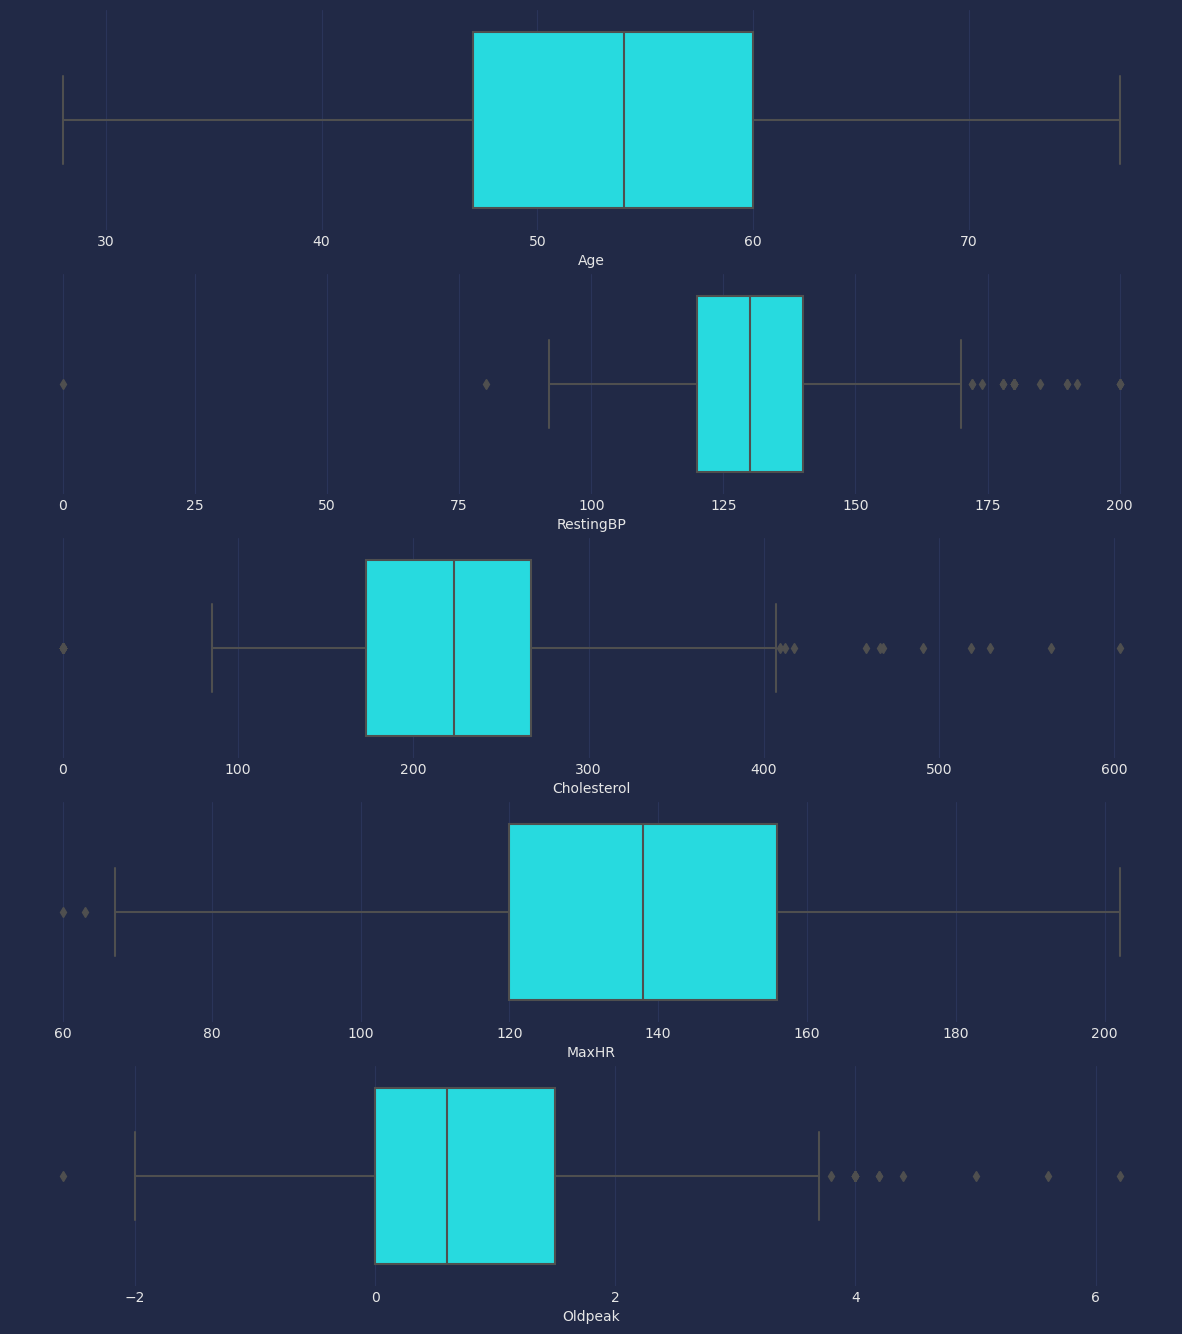

In [13]:
plt.subplots_adjust(hspace=0.2)

fig, axs = plt.subplots(5, 1, figsize=(15,20))
i=1
for feature in continuos_f:
    if feature not in ["HeartDisease"]:
        plt.subplot(6,1,i)
        sns.boxplot(data=df, x=feature)
        i+=1

<Figure size 640x480 with 0 Axes>

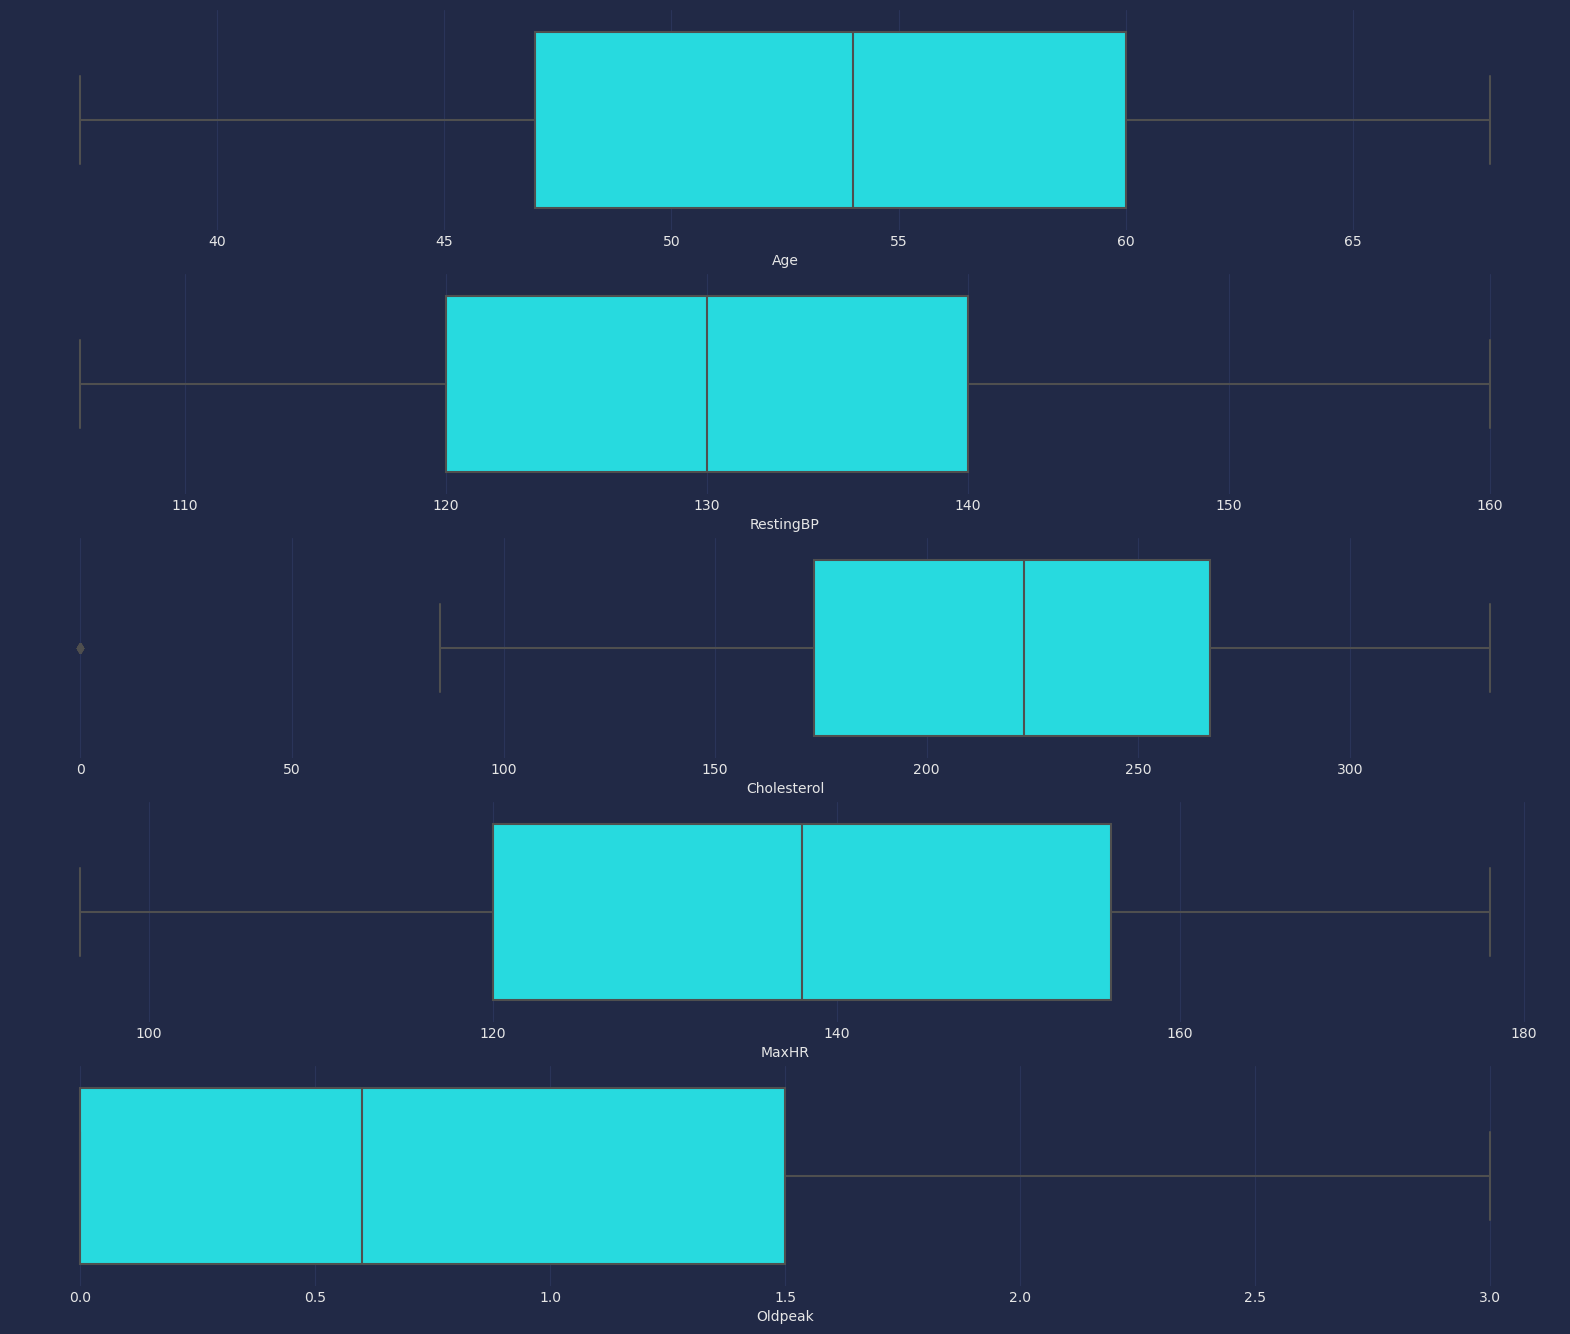

In [14]:
from scipy.stats.mstats import winsorize

def detect_outliers(df, columns, method="IQR", llimit=0.05, ulimit=0.05):
    df_ = df.copy()
    for col in columns:
        if method == "IQR":
            Q1 = df_[col].quantile(0.25)
            Q3 = df_[col].quantile(0.75)
            IQR = Q3 - Q1
            interval = ((df_[col] < Q1 - 1.5*IQR) | (df_[col] > Q3 + 1.5*IQR))
            df_.loc[interval, col] = df_.loc[~interval, col].mean()
        if method == "WIN":
            df_[col] = winsorize(df_[col], limits = [llimit,ulimit])
    return df_

df_clean = detect_outliers(df, continuos_f, "WIN")

plt.subplots_adjust(hspace=0.2)

fig, axs = plt.subplots(5, 1, figsize=(20,20))
i=1
for feature in continuos_f:
    if feature not in ["HeartDisease"]:
        plt.subplot(6,1,i)
        sns.boxplot(data=df_clean, x=feature)
        i+=1

We have values of zeros in the Cholesterol feature, these values are a human error since a patient with a zero cholesterol value means that he is dead. We can eliminate these values, but first we see the number of zeros since if the number is large we cannot eliminate them.

In [15]:
print(f"These values of zeros represent the {len(df_clean[df_clean['Cholesterol'] == 0])*100/len(df_clean)}% of our dataset")

These values of zeros represent the 18.736383442265794% of our dataset


Ok, we cannot eliminate them, 19% is a big number. We will do a Winsorization with different lower limit and in this way we will cut these values.

<AxesSubplot:xlabel='Cholesterol'>

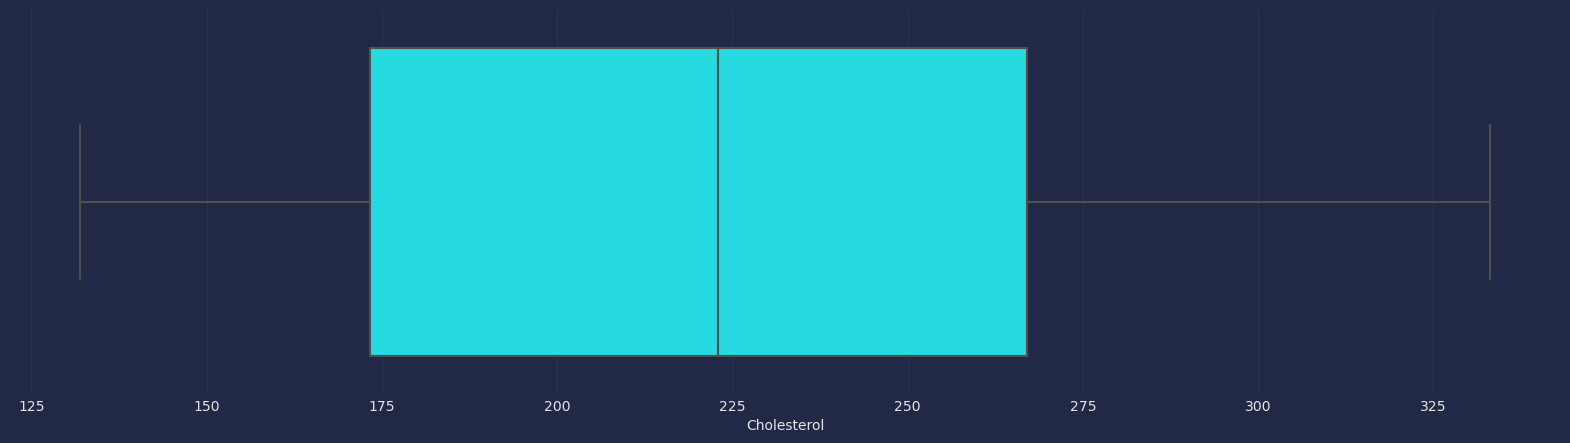

In [16]:
df_clean = detect_outliers(df_clean, ["Cholesterol"], "WIN", llimit=0.2)

plt.figure(figsize=(20,5))
sns.boxplot(data=df_clean, x="Cholesterol")

### 📈 Before and after cleaning outliers:

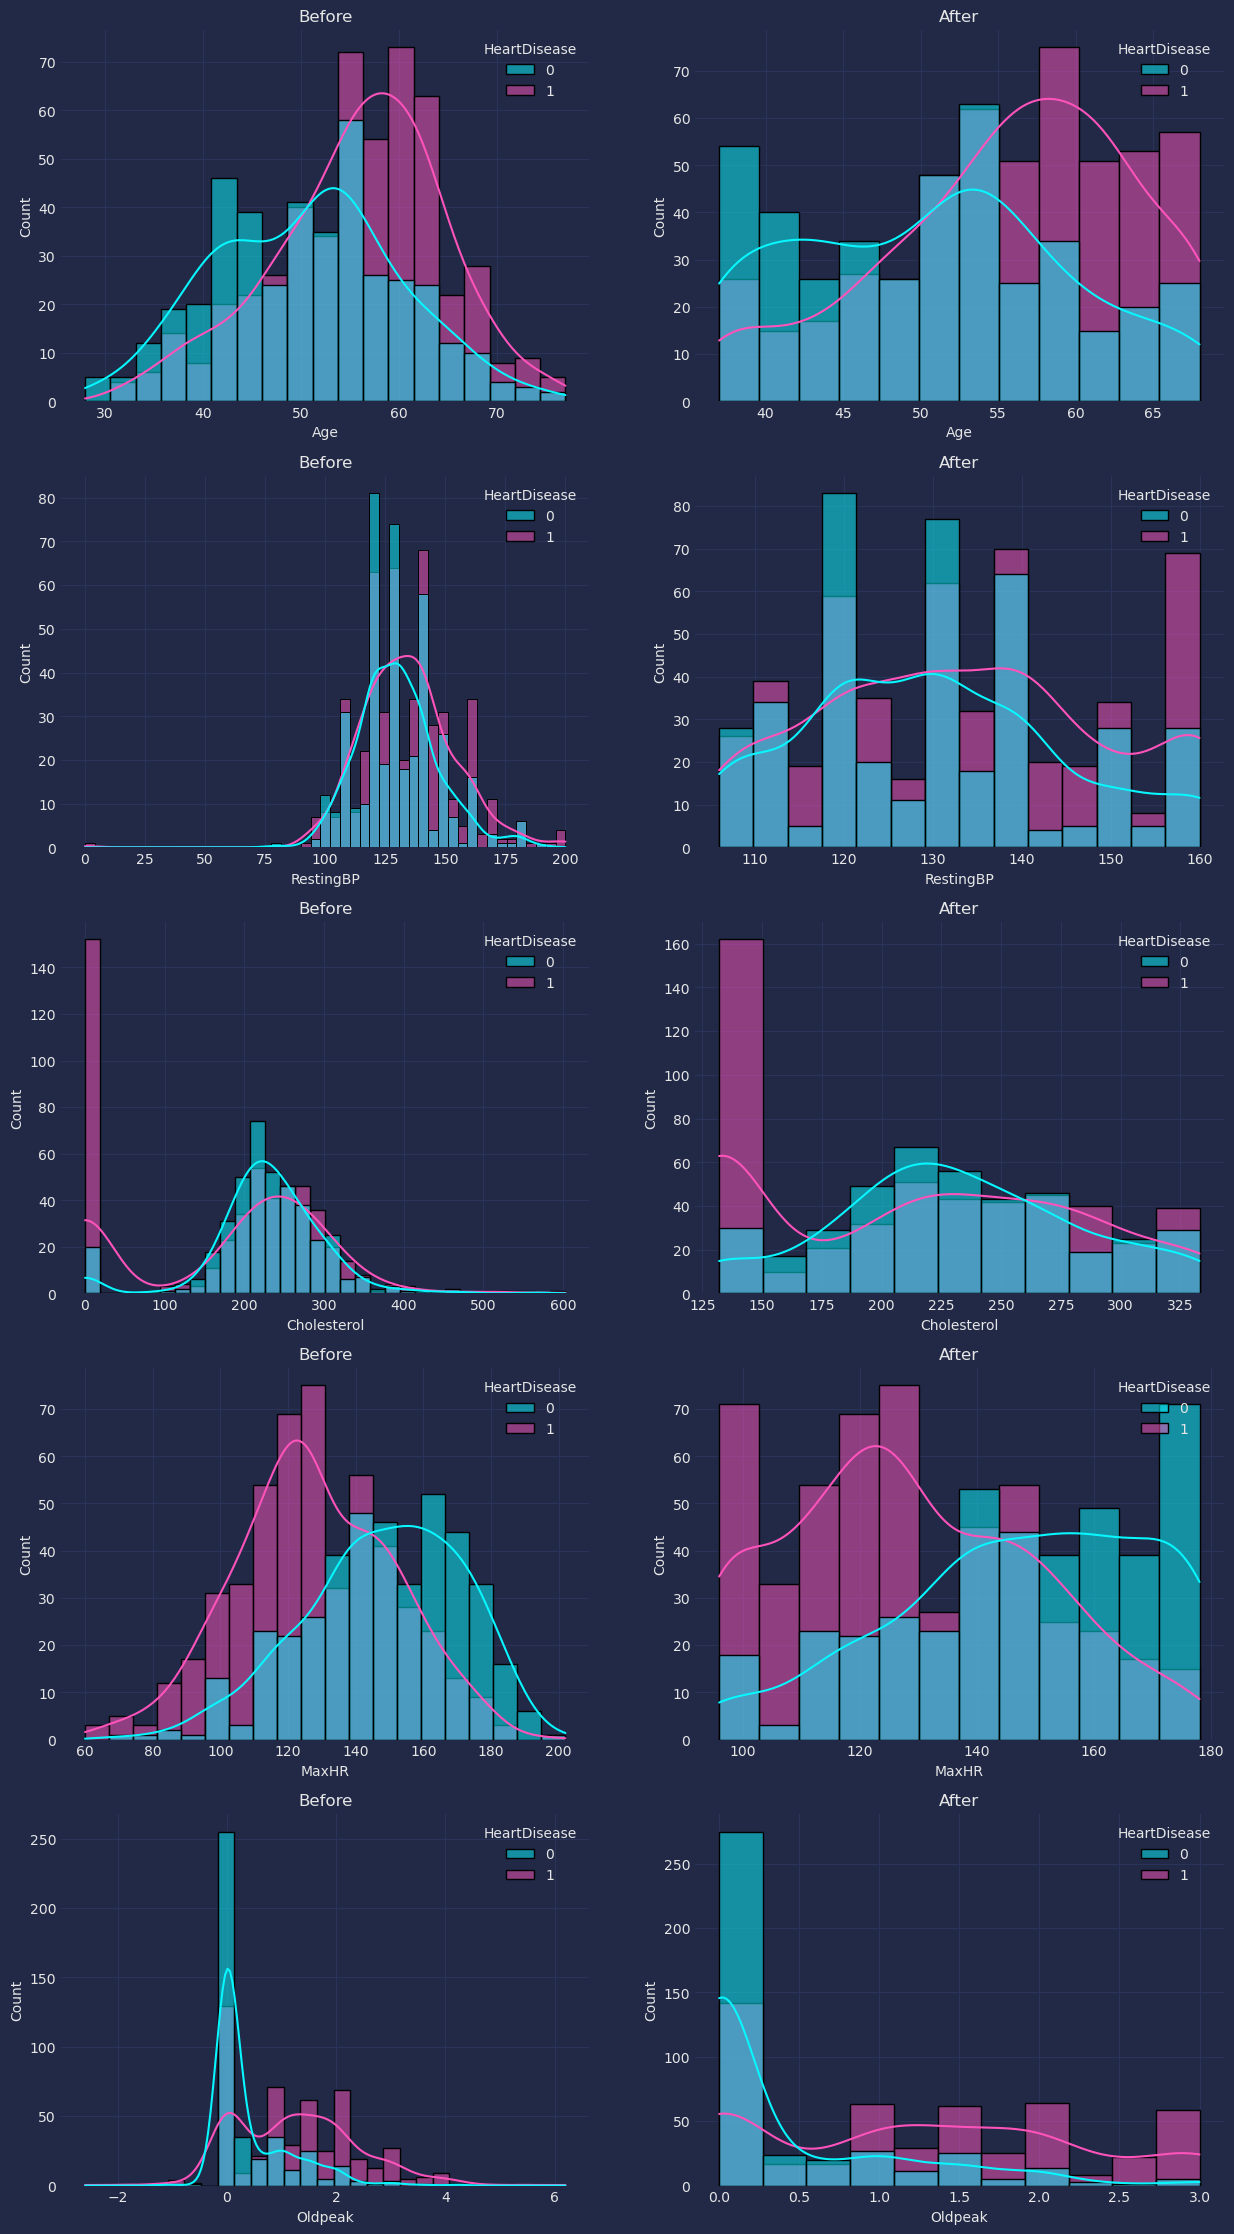

In [17]:
fig, axs = plt.subplots(5, 2, figsize=(15,28))
i=0
for feature in continuos_f:
    if feature not in ["HeartDisease"]:
        sns.histplot(data=df, x=feature, kde=True, hue='HeartDisease', ax=axs[i][0])
        sns.histplot(data=df_clean, x=feature, kde=True, hue='HeartDisease', ax=axs[i][1])
        axs[i][0].title.set_text("Before")
        axs[i][1].title.set_text("After")
        i+=1

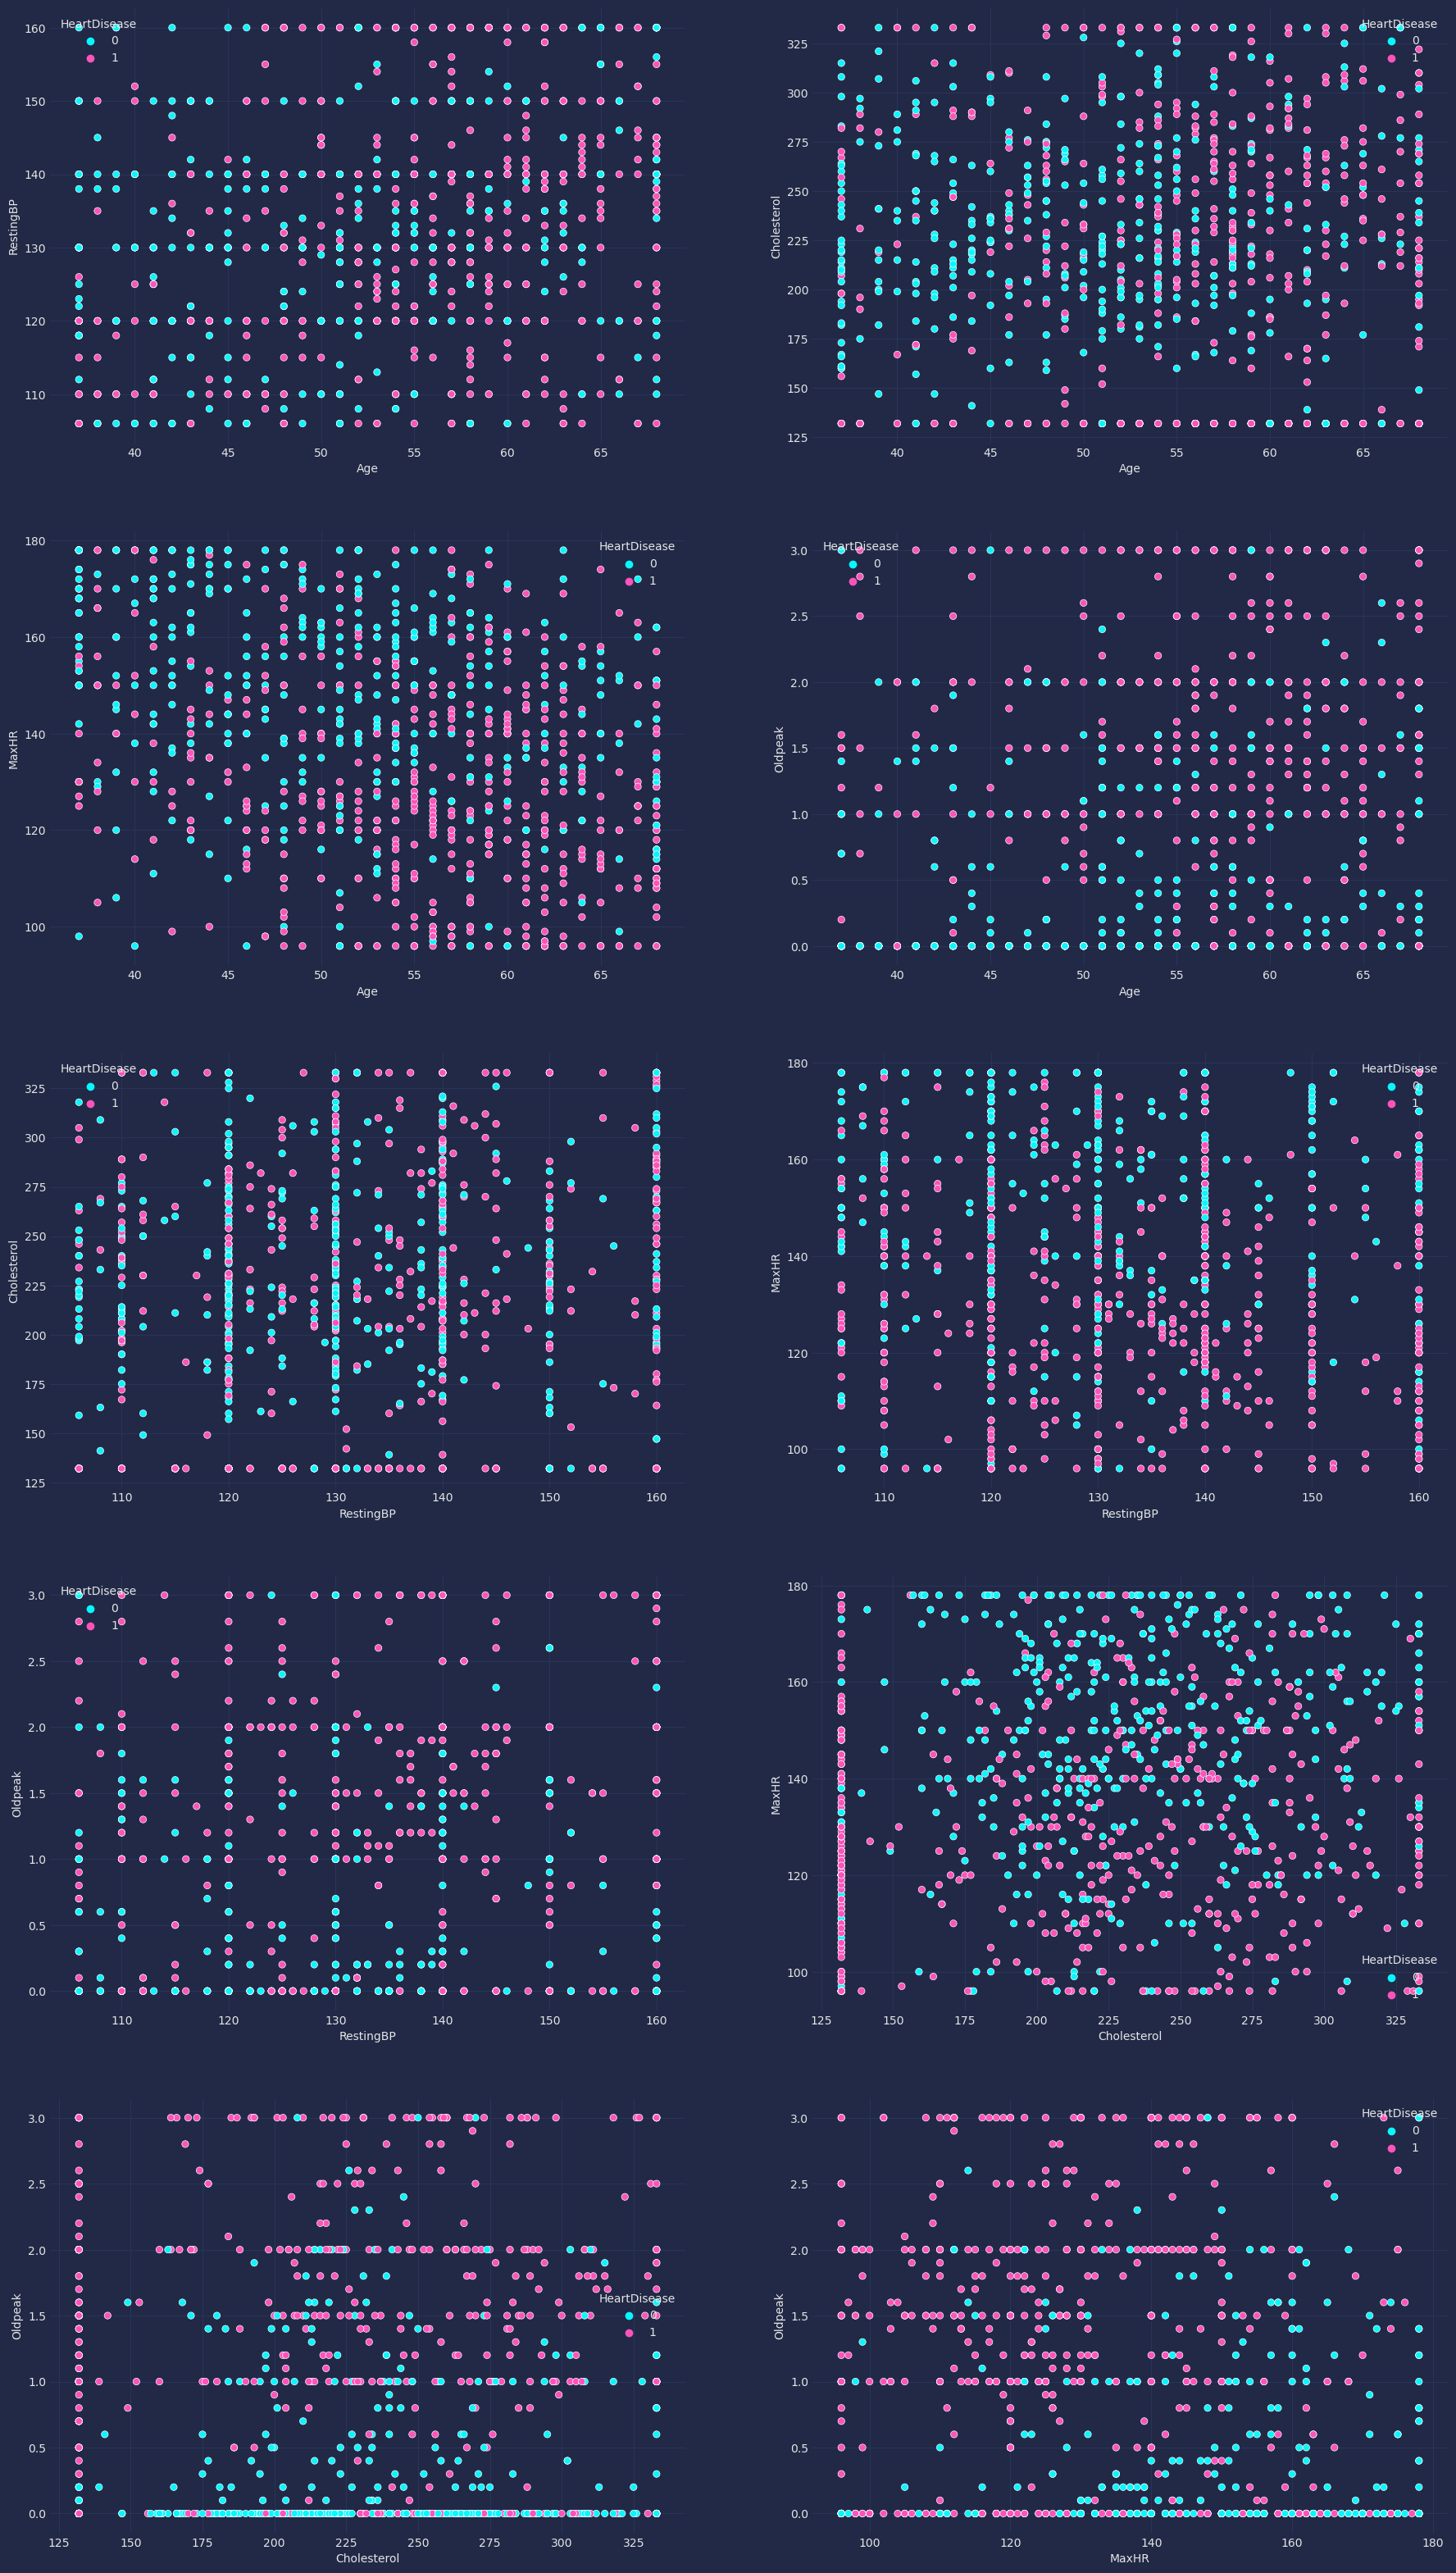

In [18]:
plt.subplots(5, 2, figsize=(22, 40))

continuos_f_cpy = continuos_f.copy()
i=0
for x in continuos_f:
    continuos_f_cpy.remove(x)
    for y in continuos_f_cpy:
        i+=1
        plt.subplot(5, 2, i)
        sns.scatterplot(data=df_clean, x=x, y=y, hue="HeartDisease")

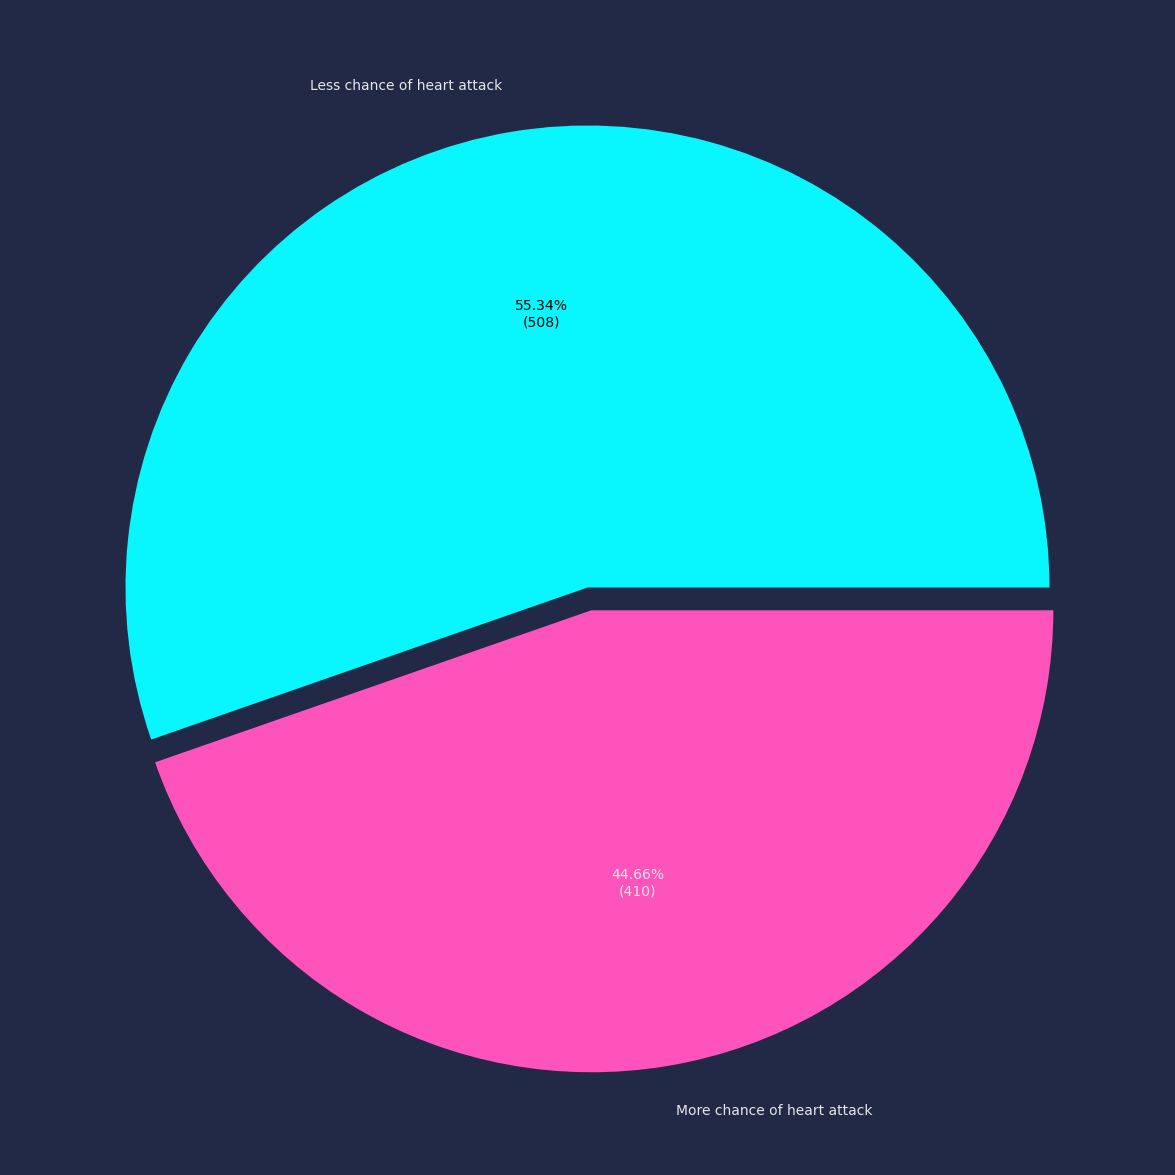

In [19]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.2f}%\n({v:d})'.format(pct, v=val)
        return my_format

labels = ["Less chance of heart attack", "More chance of heart attack"]

plt.figure(figsize=(15,15))
counts = df_clean["HeartDisease"].value_counts()
_, _, autotexts = plt.pie(counts, labels=labels, autopct=autopct_format(counts), explode=(0, 0.05))
autotexts[0].set_color('black')

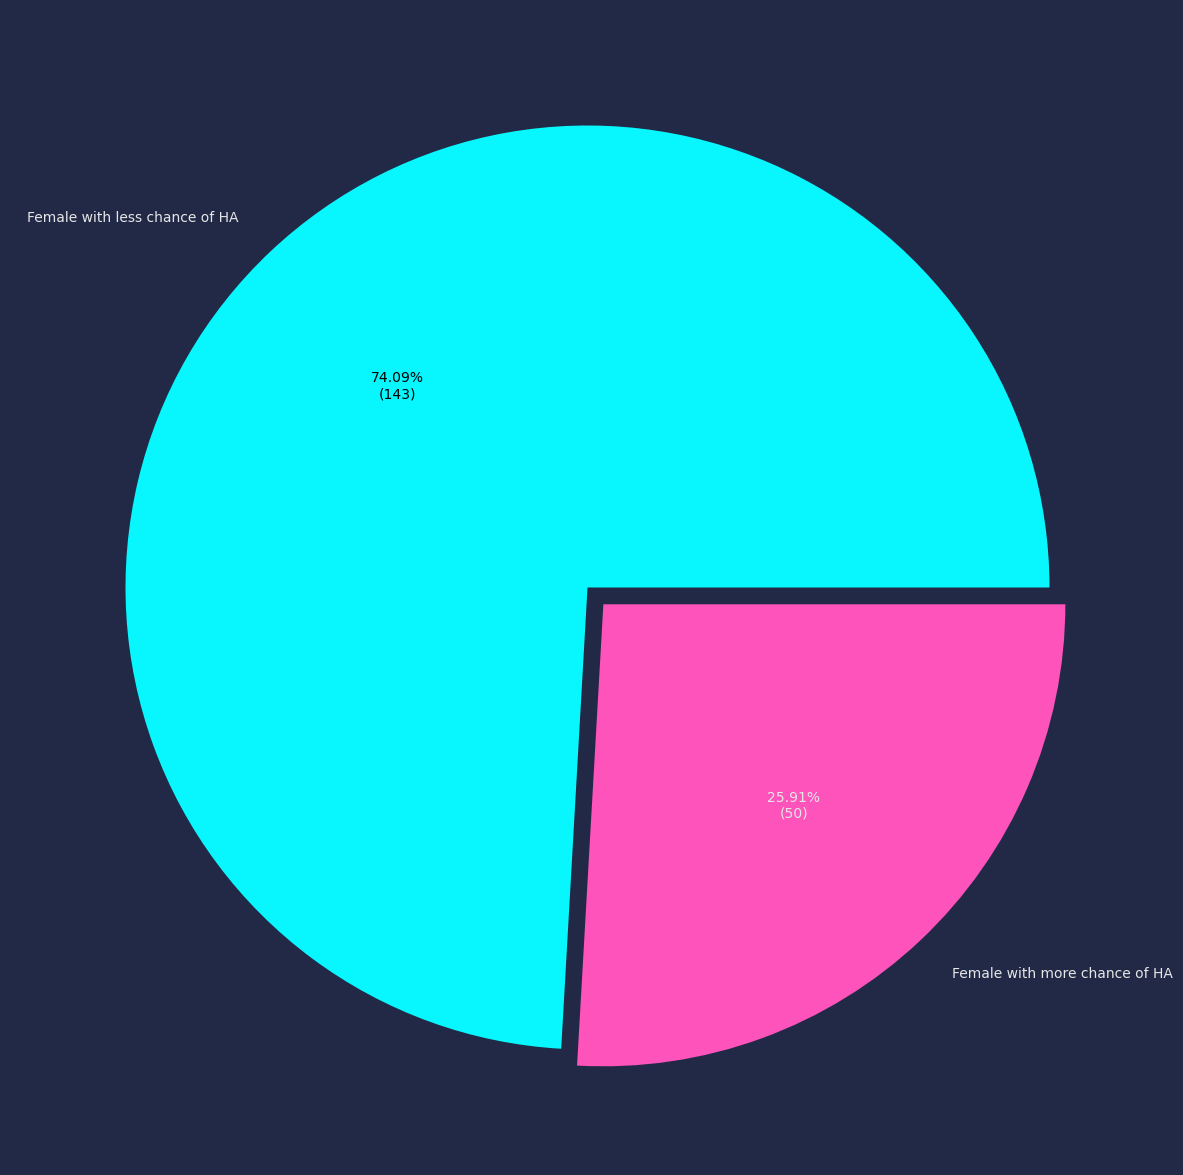

In [20]:
labels = ["Female with less chance of HA",
          "Female with more chance of HA"]

plt.figure(figsize=(15,15))
counts = df_clean.loc[df_clean["Sex"] == 'F',"HeartDisease"].value_counts()
_, _, autotexts = plt.pie(counts, labels=labels, autopct=autopct_format(counts), explode=(0, 0.05))
autotexts[0].set_color('black')

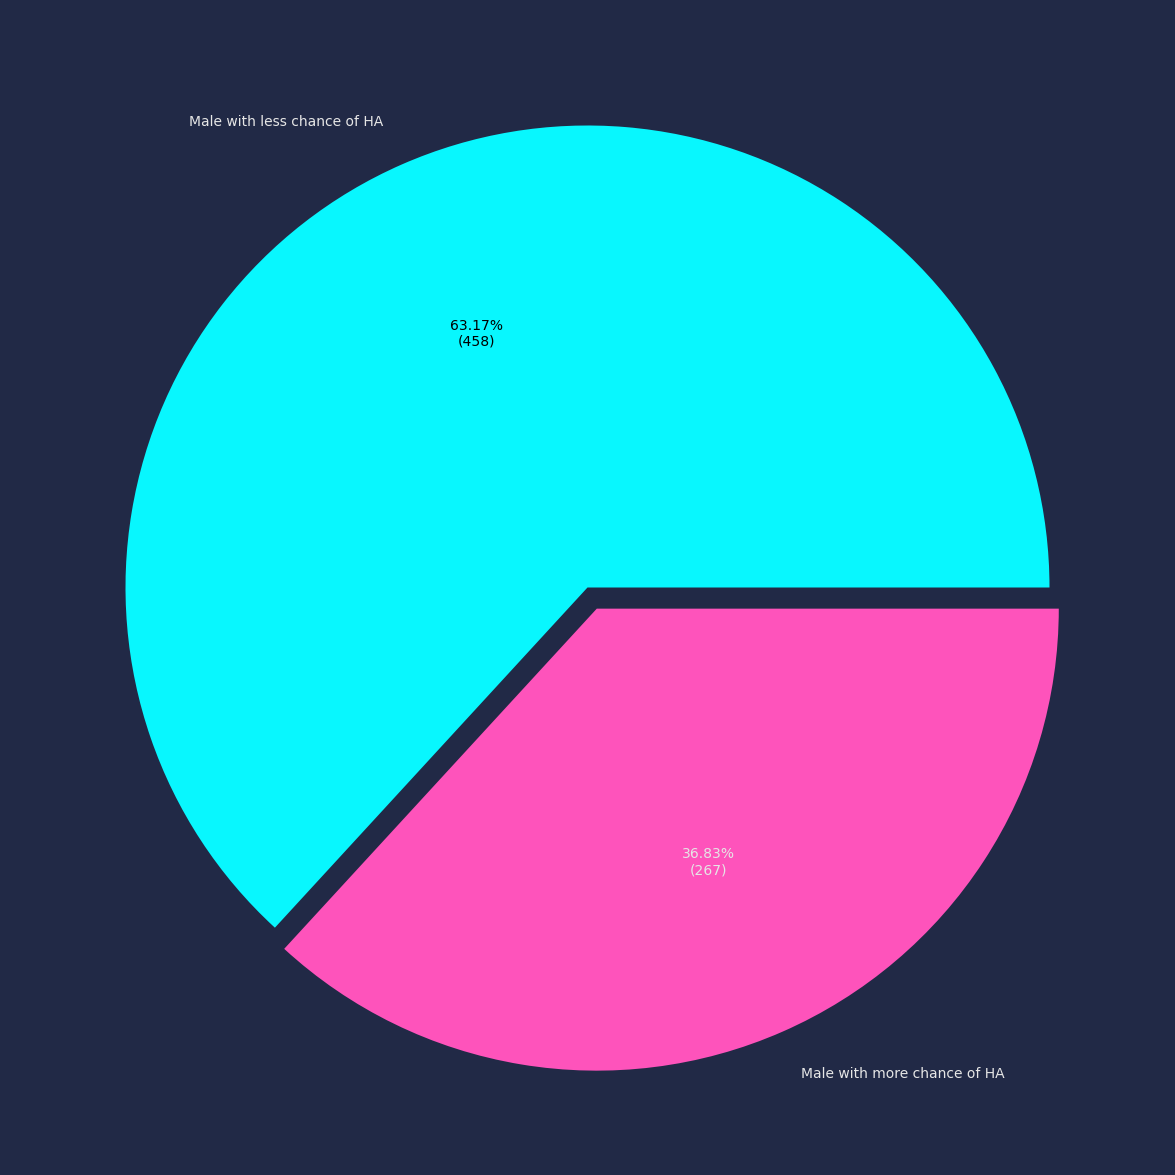

In [21]:
labels = ["Male with less chance of HA",
          "Male with more chance of HA"]

plt.figure(figsize=(15,15))
counts = df_clean.loc[df_clean["Sex"] == 'M',"HeartDisease"].value_counts()
_, _, autotexts = plt.pie(counts, labels=labels, autopct=autopct_format(counts), explode=(0, 0.05))
autotexts[0].set_color('black')

<Figure size 2000x4000 with 0 Axes>

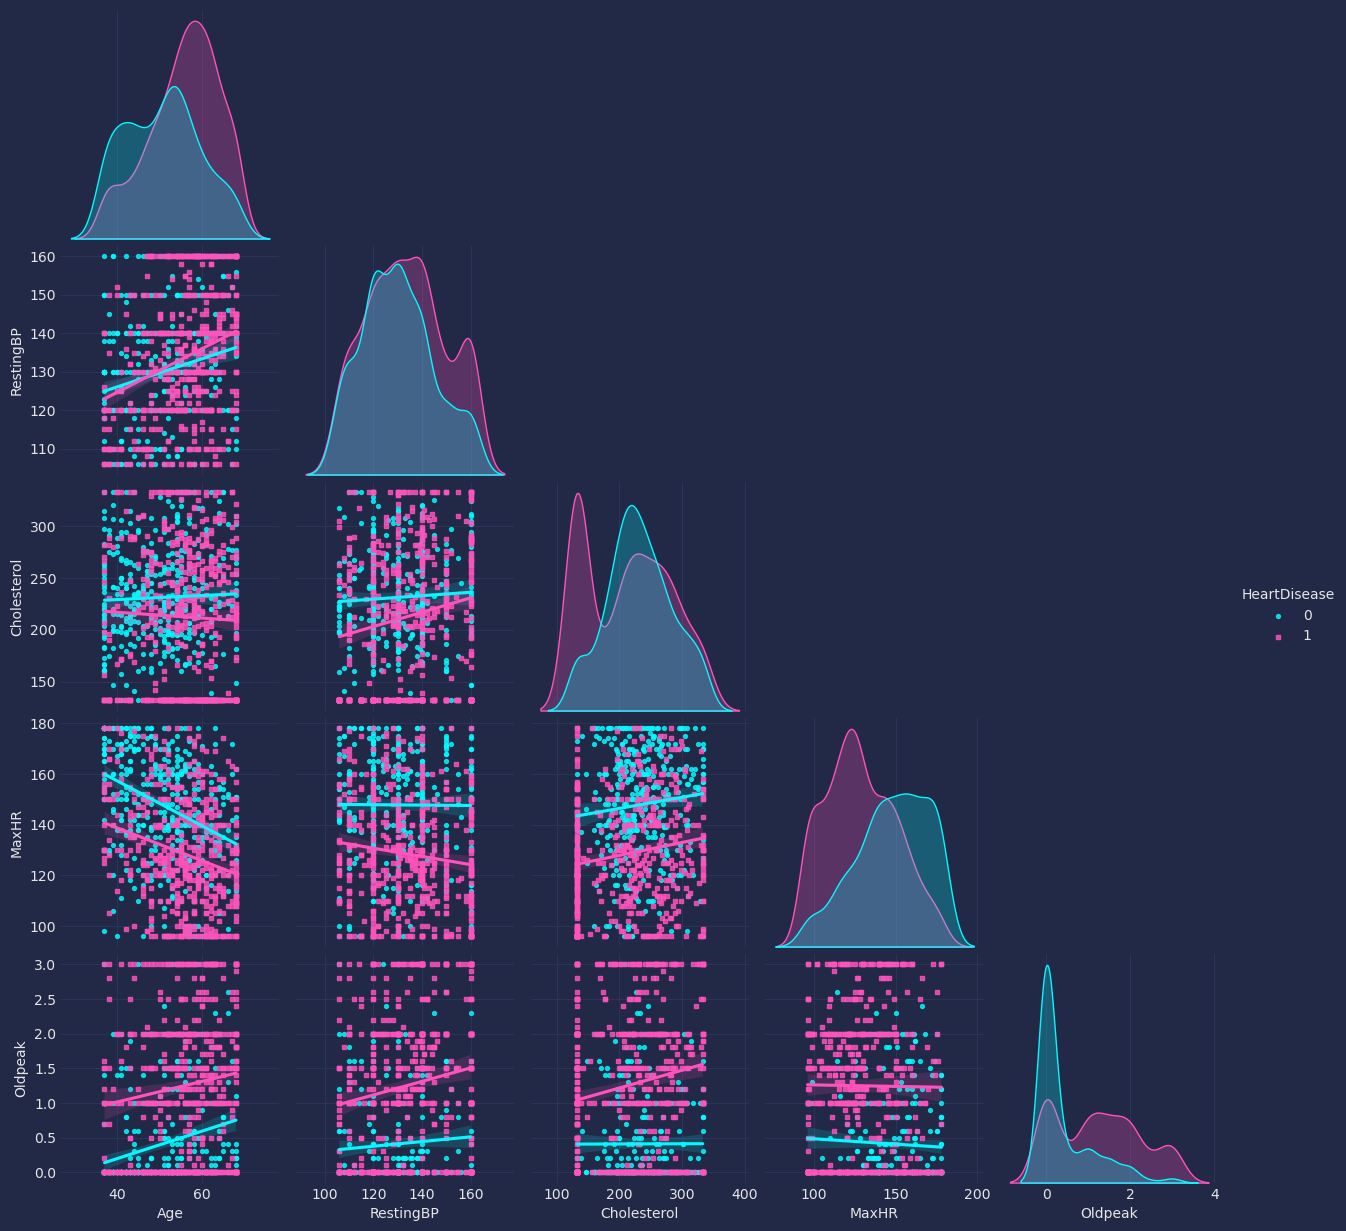

In [22]:
plt.figure(figsize=(20,40))
sns.pairplot(data=df_clean[continuos_f + ["HeartDisease"]], hue="HeartDisease", kind="reg", corner=True, markers=["o", "s"], plot_kws={ 'scatter_kws': {'alpha': 0.8, 's':8}})

****

# 🔢 Features encoding

## Binary features enconding

In [23]:
df_clean["Sex"] = df_clean["Sex"].map({'M':1, 'F':0})
df_clean["ExerciseAngina"] = df_clean["ExerciseAngina"].map({'N':0, 'Y':1})
df_clean

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150,195,0,Normal,122,0,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,TA,110,264,0,Normal,132,0,1.2,Flat,1
914,68,1,ASY,144,193,1,Normal,141,0,3.0,Flat,1
915,57,1,ASY,130,132,0,Normal,115,1,1.2,Flat,1
916,57,0,ATA,130,236,0,LVH,174,0,0.0,Flat,1


## Data Binning

In [24]:
df_bin = df_clean.copy()
for feature in continuos_f:
    bins = 5
    df_bin[feature] = pd.cut(df[feature], bins=bins, labels=range(bins)).astype(np.int64)
df_bin

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,1,1,ATA,3,2,0,Normal,3,0,1,Up,0
1,2,0,NAP,3,1,0,Normal,3,0,2,Flat,1
2,0,1,ATA,3,2,0,ST,1,0,1,Up,0
3,2,0,ASY,3,1,0,Normal,1,1,2,Flat,1
4,2,1,NAP,3,1,0,Normal,2,0,1,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,1,1,TA,2,2,0,Normal,2,0,2,Flat,1
914,4,1,ASY,3,1,1,Normal,2,0,3,Flat,1
915,2,1,ASY,3,1,0,Normal,1,1,2,Flat,1
916,2,0,ATA,3,1,0,LVH,4,0,1,Flat,1


## One-hot encoding

In [25]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 86.2+ KB


In [26]:
df_dumm = pd.get_dummies(df_clean, columns = categorical_f)
df_dumm

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,0,0,1,0,0,0,1,0,0,0,1
1,49,0,160,180,0,156,0,1.0,1,0,0,1,0,0,1,0,0,1,0
2,37,1,130,283,0,98,0,0.0,0,0,1,0,0,0,0,1,0,0,1
3,48,0,138,214,0,108,1,1.5,1,1,0,0,0,0,1,0,0,1,0
4,54,1,150,195,0,122,0,0.0,0,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,110,264,0,132,0,1.2,1,0,0,0,1,0,1,0,0,1,0
914,68,1,144,193,1,141,0,3.0,1,1,0,0,0,0,1,0,0,1,0
915,57,1,130,132,0,115,1,1.2,1,1,0,0,0,0,1,0,0,1,0
916,57,0,130,236,0,174,0,0.0,1,0,1,0,0,1,0,0,0,1,0


****

# ⚖️ Correlations between features and label:

In [27]:
df_dumm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    int64  
 1   Sex                918 non-null    int64  
 2   RestingBP          918 non-null    int64  
 3   Cholesterol        918 non-null    int64  
 4   FastingBS          918 non-null    int64  
 5   MaxHR              918 non-null    int64  
 6   ExerciseAngina     918 non-null    int64  
 7   Oldpeak            918 non-null    float64
 8   HeartDisease       918 non-null    int64  
 9   ChestPainType_ASY  918 non-null    uint8  
 10  ChestPainType_ATA  918 non-null    uint8  
 11  ChestPainType_NAP  918 non-null    uint8  
 12  ChestPainType_TA   918 non-null    uint8  
 13  RestingECG_LVH     918 non-null    uint8  
 14  RestingECG_Normal  918 non-null    uint8  
 15  RestingECG_ST      918 non-null    uint8  
 16  ST_Slope_Down      918 non

<AxesSubplot:>

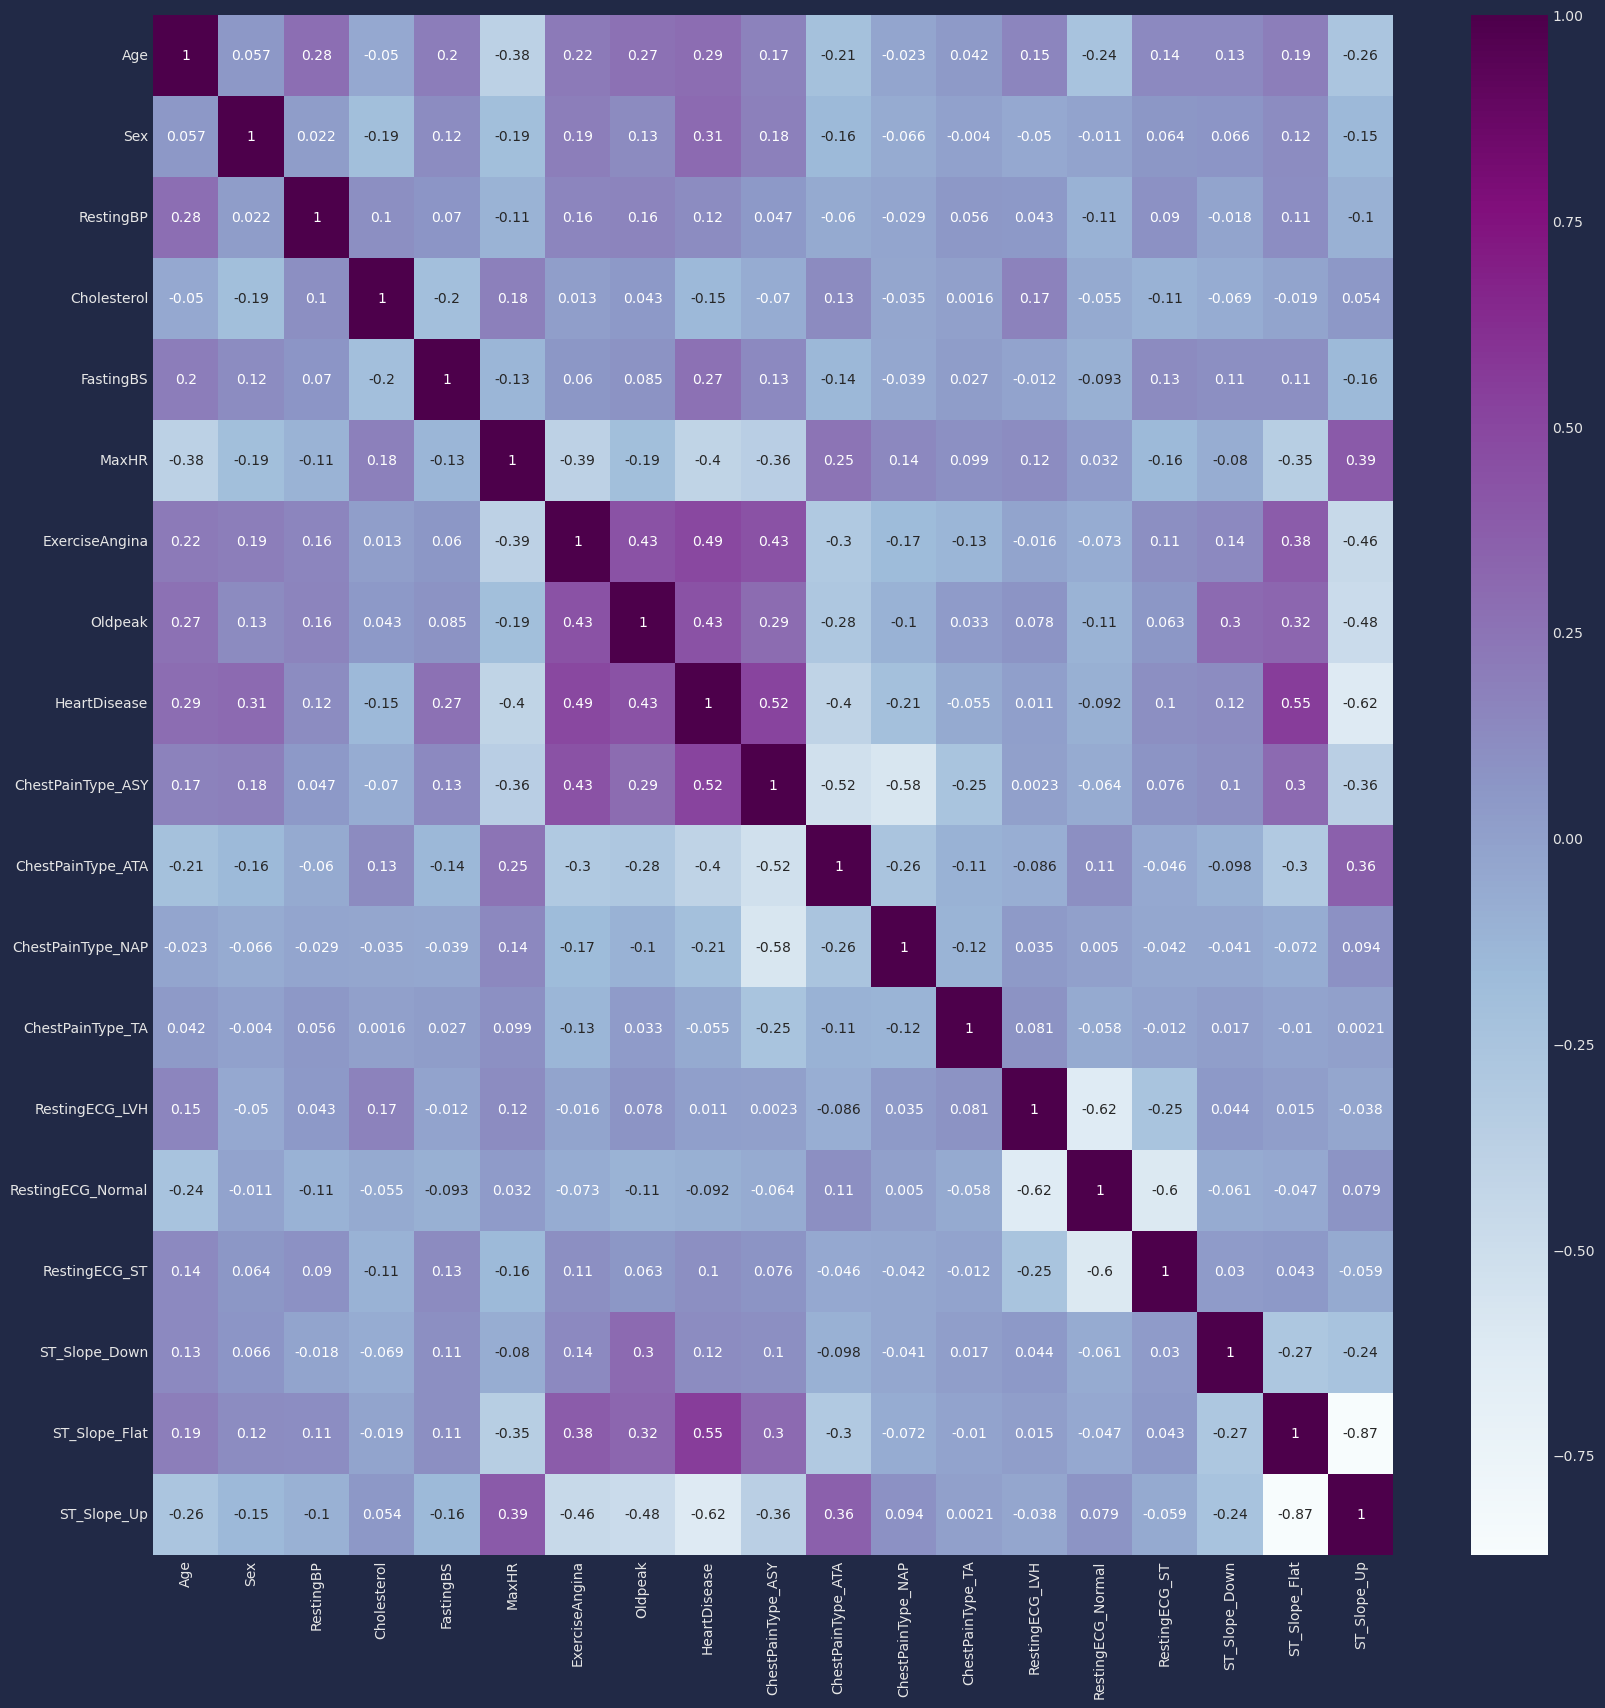

In [28]:
plt.figure(figsize=(20,20))
df_corr = df_dumm.corr()
sns.heatmap(df_corr, annot=True, cmap="BuPu")

# Dealing with imbalaced data

In [29]:
df_dumm["HeartDisease"].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

In [30]:
from imblearn.over_sampling import SMOTE

X = df_dumm.drop(["HeartDisease"], axis=1)
y = df_dumm["HeartDisease"]

oversample = SMOTE(random_state=42, k_neighbors=10)
X, y = oversample.fit_resample(X, y)
y.value_counts()

0    508
1    508
Name: HeartDisease, dtype: int64

# ✂️ Division into training and test sets

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.20, random_state=42, stratify=y_val)
X_train.shape, X_val.shape, X_test.shape 

((762, 18), (203, 18), (51, 18))

# Standardization and Normalization

In [32]:
std = StandardScaler()
mms = MinMaxScaler()

X_train = std.fit_transform(X_train)
X_train = mms.fit_transform(X_train)

X_val = std.transform(X_val)
X_val = mms.transform(X_val)

X_test = std.transform(X_test)
X_test = mms.transform(X_test)

****

# 🤖 Modeling

We will train three supervised learning models to tasks of classification also we will use grid search to tuning models' hyperparameters, additionally we will evaluate their performance with confusion matrix where:

<table>
    <tr>
        <th colspan="2" rowspan="2"></th>
        <th colspan="2">Predicted</th>
    </tr>
    <tr>
        <td>Negative</td>
        <td>Positive</td>
    </tr>
    <tr>
        <th rowspan="2">Actual</th>
        <td>Negative</td>
        <td>TN</td>
        <td>FP</td>
    </tr>
    <tr>
        <td>Positive</td>
        <td>FN</td>
        <td>TP</td>
    </tr>
</table>

Taking into account that:
+ Case negative: Patients with normal conditions (NC)
+ Case positive: Patients with CVDs
+ TN: The prediction tells us that the patient has NC when actually has NC.
+ TP: The prediction tells us that the patient has CVDs when actually has CVDs.
+ FN: The prediction tells us that the patient has NC when actually has CVDs.
+ FP: The prediction tells us that the patient has CVDs when actually has NC.

The worst case is a prediction of type FN, since we would be determining that the patient has normal condition, ignoring the possibility of CVD and exposing the patient to the risk of death. For this reason, we will focus to reduce these type of predictions.
However, the amount of predictions of type FP shouldn't be too large since our model will be very useless.
The score that help us to analysis the amount of predictions of type FN is the recall where:

$Recall = \frac{TP}{TP + FN}\quad\text{if}\quad FN \rightarrow 0 \Longrightarrow Recall \rightarrow 1$

Also:

$Precision = \frac{TP}{TP + FP}\quad\text{if}\quad FP \rightarrow 0 \Longrightarrow Precision \rightarrow 1$

and

$F1 = \frac{TP}{TP + \frac{FN + FP}{2}}\quad\text{if}\quad FN, FP \rightarrow 0 \Longrightarrow F1 \rightarrow 1$

In [33]:
metric = 'recall'

In [34]:
cv = 15
nFeatures = X_train.shape[1]

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1]) 
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Poisitive Rate")
    
def print_scores(y, y_pred):
    ac, pr, rc, f1 = accuracy_score(y, y_pred)*100, precision_score(y, y_pred)*100, recall_score(y, y_pred)*100, f1_score(y, y_pred, average='weighted')*100
    print(f"Accuracy:{ac}")
    print(f"Precision:{pr}")
    print(f"Recall:{rc}")
    print(f"F1-score:{f1}")
    return {'ac': ac, 'pr':pr, 'rc':rc, 'f1':f1}

In [35]:
# For purpose of testing the before code.
#raise SystemExit()

## 🟠 K-Nearest Neighbors Classifier

#### We train the model

In [36]:
param_grid = [{
    'n_neighbors':np.arange(5, 21),
    'weights':['uniform', 'distance'],
    'p':[1, 2],
}]

knn_clf = KNeighborsClassifier()
grid_knn = GridSearchCV(knn_clf, param_grid, cv=cv, scoring=metric)
grid_knn.fit(X_val, y_val)

GridSearchCV(cv=15, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
                          'p': [1, 2], 'weights': ['uniform', 'distance']}],
             scoring='recall')

In [37]:
best_knn_clf = grid_knn.best_estimator_
grid_knn.best_params_

{'n_neighbors': 14, 'p': 2, 'weights': 'distance'}

<AxesSubplot:>

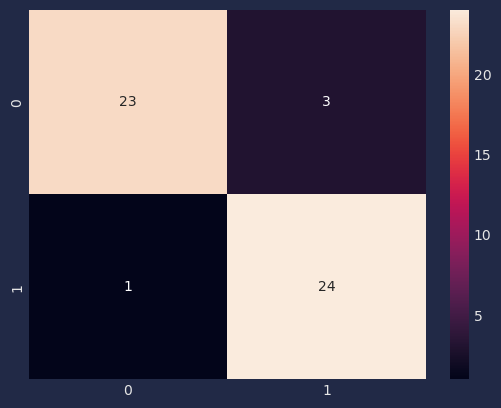

In [38]:
best_knn_clf.fit(X_train, y_train)
y_test_knn = best_knn_clf.predict(X_test)
conf_mx = confusion_matrix(y_test, y_test_knn)
sns.heatmap(conf_mx, annot=True, fmt='')

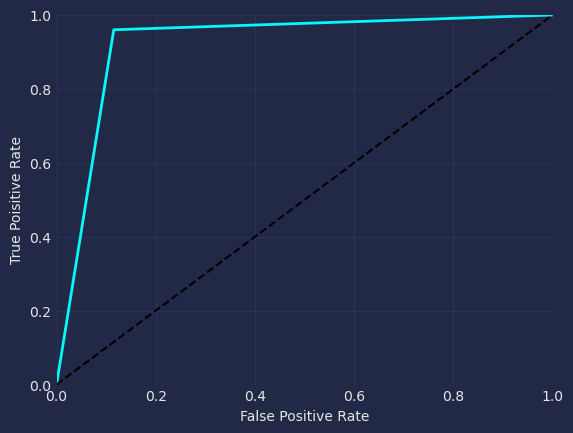

In [39]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_test_knn)
plot_roc_curve(fpr_knn, tpr_knn, "K-Nearest Neighbors")
plt.show()

In [40]:
pd.DataFrame(data=classification_report(y_test, y_test_knn, digits=6, output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.958333,0.884615,0.920000,26.000000
1,0.888889,0.960000,0.923077,25.000000
accuracy,0.921569,0.921569,0.921569,0.921569
macro avg,0.923611,0.922308,0.921538,51.000000
weighted avg,0.924292,0.921569,0.921508,51.000000


In [41]:
knn_scores = print_scores(y_test, y_test_knn)

Accuracy:92.15686274509804
Precision:88.88888888888889
Recall:96.0
F1-score:92.15082956259425


## 🟣 C-Support Vector Classifier.

#### We train the model

In [42]:
param_grid = [{
    "C": np.linspace(1, 1.5, 10),
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "gamma": ['scale', 'auto']
}]

svc_clf = SVC(random_state=42)
grid_svc = GridSearchCV(svc_clf, param_grid, scoring=metric, cv=cv)
grid_svc.fit(X_val, y_val)

GridSearchCV(cv=15, estimator=SVC(random_state=42),
             param_grid=[{'C': array([1.        , 1.05555556, 1.11111111, 1.16666667, 1.22222222,
       1.27777778, 1.33333333, 1.38888889, 1.44444444, 1.5       ]),
                          'gamma': ['scale', 'auto'],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             scoring='recall')

In [43]:
best_svc_clf = grid_svc.best_estimator_
grid_svc.best_params_

{'C': 1.4444444444444444, 'gamma': 'scale', 'kernel': 'sigmoid'}

<AxesSubplot:>

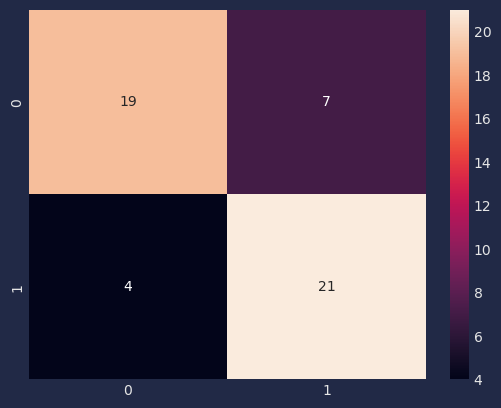

In [44]:
best_svc_clf.fit(X_train, y_train)
y_test_svc = best_svc_clf.predict(X_test)
conf_mx = confusion_matrix(y_test, y_test_svc)
sns.heatmap(conf_mx, annot=True, fmt='')

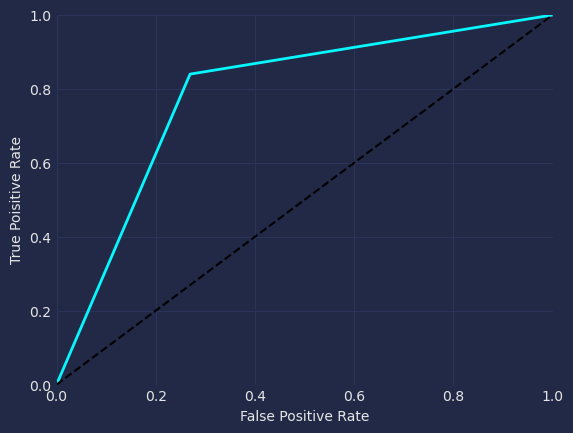

In [45]:
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_test_svc)
plot_roc_curve(fpr_svc, tpr_svc, "SVC")
plt.show()

In [46]:
pd.DataFrame(data=classification_report(y_test, y_test_svc, digits=6, output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.826087,0.730769,0.775510,26.000000
1,0.750000,0.840000,0.792453,25.000000
accuracy,0.784314,0.784314,0.784314,0.784314
macro avg,0.788043,0.785385,0.783982,51.000000
weighted avg,0.788789,0.784314,0.783815,51.000000


In [47]:
svc_scores = print_scores(y_test, y_test_svc)

Accuracy:78.43137254901961
Precision:75.0
Recall:84.0
F1-score:78.38154129576358


## 🟢 Random Forest Classifier

#### We train the model

In [48]:
nFeatures

18

In [49]:
param_grid = [{"n_estimators":[650, 700, 750, 800],
               'criterion':['gini','entropy'],
               "max_features":[nFeatures-9, nFeatures-8, nFeatures-5]
              }]
rf_clf = RandomForestClassifier(random_state=42)
grid_forest = GridSearchCV(rf_clf, param_grid, cv=cv, scoring=metric)
grid_forest.fit(X_val, y_val)

GridSearchCV(cv=15, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_features': [9, 10, 13],
                          'n_estimators': [650, 700, 750, 800]}],
             scoring='recall')

In [50]:
best_rf_clf = grid_forest.best_estimator_
best_rf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 9,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 650,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

<AxesSubplot:>

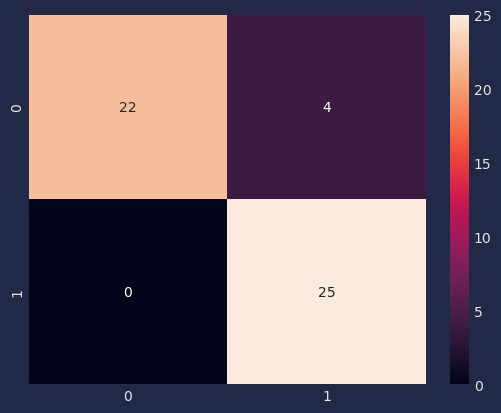

In [51]:
best_rf_clf.fit(X_train, y_train)
y_test_rf = best_rf_clf.predict(X_test)
conf_mx = confusion_matrix(y_test, y_test_rf)
sns.heatmap(conf_mx, annot=True, fmt='')

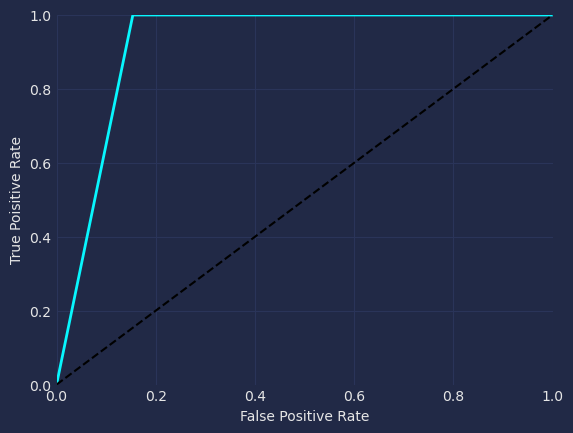

In [52]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, y_test_rf)
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.show()

In [53]:
pd.DataFrame(data=classification_report(y_test, y_test_rf, digits=6, output_dict=True)).transpose()

,precision,recall,f1-score,support
0,1.000000,0.846154,0.916667,26.000000
1,0.862069,1.000000,0.925926,25.000000
accuracy,0.921569,0.921569,0.921569,0.921569
macro avg,0.931034,0.923077,0.921296,51.000000
weighted avg,0.932387,0.921569,0.921206,51.000000


In [54]:
rf_scores = print_scores(y_test, y_test_rf)

Accuracy:92.15686274509804
Precision:86.20689655172413
Recall:100.0
F1-score:92.12055192447349


# 📏 Model Score Comparisons

In [55]:
scores = pd.DataFrame(data=[list(knn_scores.values()), list(svc_scores.values()), list(rf_scores.values())], columns=list(knn_scores.keys()))
scores = scores.T.rename(columns={0:"K-Nearest Neighbors", 1:"C-Support Vector", 2:"Random Forest"})
scores.style.highlight_max(color = 'green', axis = 1).highlight_min(color = 'red', axis = 1)

,K-Nearest Neighbors,C-Support Vector,Random Forest
ac,92.156863,78.431373,92.156863
pr,88.888889,75.000000,86.206897
rc,96.000000,84.000000,100.000000
f1,92.150830,78.381541,92.120552


According to our focus the best recall score was present for the Random Forest classifier, we must find a balance between recall score and precision score, <span style="color:green; font-weight: bold;">for me the best model is the Random Forest Classifier.</span>